In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import glob
from astropy.io import fits
from astropy.stats import sigma_clip
from scipy import optimize, signal
import pickle
import warnings
warnings.filterwarnings("ignore")
import statistics
from astropy.visualization import simple_norm
import matplotlib.patches as patches

### personally developed pipeline scrip

### set-up graphs for publication
import matplotlib as mpl
mpl.rcParams['xtick.major.size'] = 10
mpl.rcParams['xtick.major.width'] = 3
mpl.rcParams['ytick.major.size'] = 10
mpl.rcParams['ytick.major.width'] = 3
mpl.rcParams['mathtext.fontset'] = 'custom'
mpl.rcParams['axes.labelweight'] = 'bold'
mpl.rcParams['font.weight'] = 'bold'
mpl.rcParams['font.size'] = 18
mpl.rcParams['axes.linewidth'] = 6
plt.rcParams['font.size'] = '18'

In [2]:
def wfc3_extract(hist_med, plnm='W79', numxaps=5, numyaps=10):
    fpath='/Users/fixit/Desktop/Python/Research/'
    filenames = glob.glob(fpath +'/LTT1445_fits_files/'+ '/Test/'+'*flt.fits') #CHANGE if storing 
                               #your exposures in a different folder structure
    filenames = sorted(filenames)
#    directimage = glob.glob(fpath +'*ima.fits')
#     flatimage = glob.glob(fpath + '*G141.flat*')
#     hdulist = fits.open(flatimage[0])
#     flat = hdulist[0].data
#     flat = flat[245:245+522, 245:245+522] #CHANGE Will need to look in header 
#             #information or look at image using DS9 to find ACTUAL pixel 
#             #numbers on detector that correspond to origin in image.
#     hdulist.close()
    
    for i in range(0, len(filenames)):
        hdulist = fits.open(filenames[i])

########  make the arrays we will need  #######################
        if i == 0:
            subarray=512
            subarray2=513
            #nsamp=hdulist[0].header['NSAMP']
            nsamp=1
            print (str(len(filenames))+' files')
            nsamp=int(nsamp)
            temp=np.zeros(shape=(subarray, subarray2, nsamp))
            images=np.zeros(shape=(subarray, subarray2, nsamp, len(filenames)))
            time=np.zeros(len(filenames))
            raDeg=np.zeros(len(filenames))
            decDeg=np.zeros(len(filenames))
            wlc=np.zeros(shape=(len(filenames), numyaps, numxaps))
            scan_ang=np.zeros(len(filenames))
            ndrwhite=np.zeros(shape=(nsamp, numyaps, numxaps))  
            flux=np.zeros(shape=(nsamp, numyaps, numxaps))
            error=np.zeros(shape=(nsamp, numyaps, numxaps))
            diff=np.zeros(shape=(numyaps, numxaps))
            wlc_error=np.zeros(shape=(len(filenames), numyaps, numxaps))
            
        if i % 25 == 0:
            print(i)        
        ###########   LOOP OVER EACH NDR   #####################  
        for j in range(0,nsamp):
            scidata=hdulist[1].data
            err=hdulist[2].data

            if j == 0:
                scidata_0 = scidata
                expstart=hdulist[0].header['EXPSTART']
                expend=hdulist[0].header['EXPEND']
                exptime=hdulist[0].header['EXPTIME']
                scan_ang[i]=hdulist[0].header['SCAN_ANG']
                scanlen=hdulist[0].header[ 'SCAN_LEN']
                raDeg = hdulist[0].header['RA_TARG']
                decDeg = hdulist[0].header['DEC_TARG']
                time[i]=0.5*(expend+expstart)
                if i ==0:
                    xybox=getbox(scidata) #THIS GETS A BOX THE SIZE OF THE SPEC
                    x_range=xybox[1]+1-xybox[0]
                    y_range=xybox[3]+1-xybox[2]
                    x_cen=np.floor((xybox[1]+1-xybox[0])/2.)
                    y_cen=np.floor((xybox[3]+1-xybox[2])/2.)

         #############  FLAT FIELD AND BACKGROUND ###############
            scidata, images=background_and_flat(scidata, images, hist_med, j, i) 

            for aprx in range(0,numxaps):
                xwidth=x_range+aprx
                
                for apry in range(0,numyaps):
                    ff=np.sum(scidata[xybox[2]-apry:xybox[3]+1+apry, xybox[0]-
                                      aprx:xybox[1]+1+aprx])
                    er=np.sum(err[xybox[2]-apry:xybox[3]+1+apry, xybox[0]-
                                      aprx:xybox[1]+1+aprx]**2.)
                    flux[j,apry, aprx]=ff  #flux = wlc
                    error[j,apry, aprx]=er

            wlc_error[i,:,:]=np.sum(error, axis=0)**0.5
            
        for jj in range(0,nsamp):
            if jj==0: 
                diff=np.zeros(shape=(numyaps, numxaps))
            else:  
                diff+=(flux[jj-1, :, :]- flux[jj]) 

        wlc[i, :, :]=diff
    print('wlc',wlc)
    plt.figure()
    plt.errorbar(time,  wlc[:,0,0], yerr=wlc_error[:,0,0], fmt='o', color='k')
    plt.xlabel('Time ($MJD_{UTC}$)')
    plt.ylabel('Flux (e$^-$)')
    plt.title('WFC3 Raw Light curve')
    plt.show()
       
    ###These two can be commented out but have to figure out what the 
    ###other data in that packet are still
    wlc = wlc[:,0,0]
    wlc_error = wlc_error[:,0,0]

    
#     outpath = fpath+'W79_data/'
#     fileObject = open(outpath+'wlc_extract_out', 'wb')
#     pickle.dump([time, wlc, wlc_error, raDeg, decDeg, scidata_0, scidata, 
#                  xybox], fileObject)
#     fileObject.close()
    
    return time, wlc, wlc_error, raDeg, decDeg, scidata_0, scidata, xybox

In [3]:
def background_and_flat(scidata, images, hist_med, j, i):
#     scidata=scidata/flat 
#     cols1=np.arange(0,15)
#     cols2=np.arange(500,522)
    cols1=np.arange(0,15)
    cols2=np.arange(513,512)
    edges=np.append(cols1,cols2)
    m = np.zeros_like(scidata)
    m[:,edges] = 1
    m[edges, :] = 1
    scidata=np.ma.masked_array(scidata, m)         
    scidata = sigma_clip(scidata, sigma=7)         
    #backbox=scidata[xybox[2]-100:xybox[2]-50, :]
    backbox=scidata[xybox[3]+50:xybox[3]+100, :] #Change range of backbox to 
                                                #be where you want the background
                                                #pulled from in form 
#                                                 #scidata[ymin, ymax, xmin, xmax]
#     bkgd = backbox.mean(axis=0)
#     #print('background',bkgd)
#     bkgd = sp.signal.medfilt(bkgd,31)
#     bkgd = np.array([bkgd,]*522)
    bkgd = hist_med
    
    
    scidata = scidata-bkgd
    scidata = sigma_clip(scidata, sigma=5)
    images[:,:,j,i]=scidata


    return scidata, images

### Finds 1st order 
def getbox(scidata):
    holdy=np.zeros(10)
    holdx=np.zeros(10)
    for xx in range(80,180,10): #CHANGE the 80 & 180 to span pixels that are on 
                                #either side of the left edge of your spectra 
                                #without encompassing contamination sources
        for yy in range(0,250): #CHANGE the 0 & 250 to span pixels that are on
                                #either side of the bottom edge of your spectra
                                #without encompassing contamination sources
            ybot=yy
            if scidata[yy,xx] > 2*np.mean(scidata):
                break
        holdy[int((xx-80)/10-1)]=ybot #CHANGE 80 to min value chosen for xx
    ybot=int(np.median(holdy))
    
    for xx in range(80,180,10): #CHANGE the 80 & 180 to span pixels that are on 
                                #either side of the left edge of your spectra 
                                #without encompassing contamination sources
        for yy in range(450,0, -1): #CHANGE the 450 & 0 to span pixels that are 
                                #on either side of the top edge of your spectra
                                #without encompassing contamination sources
            ytop=yy
            if scidata[yy,xx] > 2*np.mean(scidata):
                break
        holdy[int((xx-80)/10-1)]=ytop #CHANGE 80 to min value chosen for xx
    ytop=int(np.median(holdy))

    for yy in range(ybot,ytop, (ytop-ybot)//6):
        for xx in range(0,350): #CHANGE the 0 & 350 to span pixels that are on 
                                #either side of the left edge of your spectra 
                                #without encompassing contamination sources
            xleft=xx
            if scidata[yy,xx] > 2*np.mean(scidata):
                break
        holdx[int((yy-ybot)/((ytop-ybot)//6)-1)]=xleft
    xleft=int(np.median(holdx))
    for yy in range(ybot,ytop, (ytop-ybot)//6):
        for xx in range(250,0, -1): #CHANGE the 250 & 0 to span pixels that are on 
                                #either side of the right edge of your spectra 
                                #without encompassing contamination sources
            xright=xx
            if scidata[yy,xx] > 2*np.mean(scidata):
                break
        holdx[int((yy-ybot)/((ytop-ybot)//6)-1)]=xright
    xright=int(np.median(holdx))
    global xybox
    xybox=np.array([xleft, xright, ybot, ytop])

    print('xybox(xleft, xright, ybot, ytop)=', xybox)
    return xybox

#time, wlc, wlc_error, raDeg, decDeg, scidata_0, scidata, xybox = wfc3_extract(plnm='W79', numxaps=5, numyaps=10)



1 files
0
xybox(xleft, xright, ybot, ytop)= [201   1 159 275]
wlc [[[0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]]]


findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.


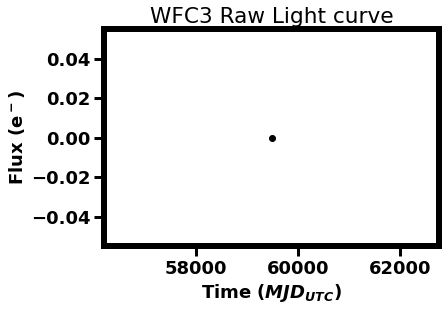

"\nfpath='/Users/fixit/Desktop/Python/Research/'\n\nfileObject = open(fpath+'/LTT1445_fits_files/Test/', 'rb')\n\n\nMJD_UTC, flux, flux_err, raDeg, decDeg, scidata_0, scidata, xybox = pickle.load(fileObject)\nfileObject.close()\n\n#fileObject = open(fpath+'W79_data/BJD_TDB', 'rb')\nBJD_TDB_f, flux, flux_err = pickle.load(fileObject)\nfileObject.close()\n"

In [4]:
from astropy.utils.data import get_pkg_data_filename
fpath='/Users/fixit/Desktop/Python/Research/LTT1445_fits_files/Test/'
list = glob.glob(fpath+'*.fits')
list = sorted(list)
image_file = get_pkg_data_filename(list[0])
image_data = fits.getdata(image_file, ext=0)
x = np.zeros(len(image_data))
for n in range(len(image_data)):
    x[n] = np.sum(image_data[n][:])
hist_med = np.median(x)

MJD_UTC, flux, flux_err, raDeg, decDeg, scidata_0, scidata, xybox = wfc3_extract(hist_med)
# BJD_TDB_f = mjd_bjd.mjd_bjd(MJD_UTC, flux, flux_err, raDeg, decDeg)


'''
fpath='/Users/fixit/Desktop/Python/Research/'

fileObject = open(fpath+'/LTT1445_fits_files/Test/', 'rb')


MJD_UTC, flux, flux_err, raDeg, decDeg, scidata_0, scidata, xybox = pickle.load(fileObject)
fileObject.close()

#fileObject = open(fpath+'W79_data/BJD_TDB', 'rb')
BJD_TDB_f, flux, flux_err = pickle.load(fileObject)
fileObject.close()
'''

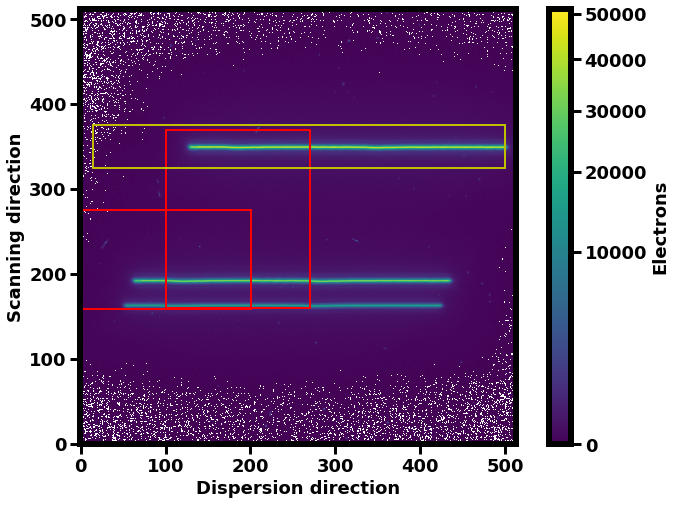

In [5]:
###View NDR of first image of first visit

# Create an ImageNormalize object
norm = simple_norm(scidata_0, 'sqrt', min_cut=0)


# Display the image
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(1, 1, 1)
im = ax.imshow(scidata_0, origin='lower', norm=norm)

#First order spectra search
rect1 = patches.Rectangle((xybox[0],xybox[2]),(xybox[1]-xybox[0]),(xybox[3]-xybox[2]), 
                          fill=False, ec='r', linewidth=2)
rect2 = patches.Rectangle((100,160),(170),(210), fill=False, ec='r', linewidth=2)
#Background region
rect3 = patches.Rectangle((15,xybox[3]+50),(485),(50), fill=False, ec='y', linewidth=2)

ax.add_patch(rect1)
ax.add_patch(rect2)
ax.add_patch(rect3)

fig.colorbar(im, label='Electrons')
ax.set_xlabel('Dispersion direction', fontsize=18)
ax.set_ylabel('Scanning direction', fontsize=18)
fig.show()